In [ ]:
!sudo apt install portaudio19-dev
!pip install pyaudio
import pyaudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (184 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEn

In [ ]:

!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 24.7 MB/s eta 0:00:00


In [ ]:


# Speech Detection System
# This code implements a complete speech detection system with:
# - Acoustic Analysis
# - Speech Recognition
# - Noise Filtering
# - Emotional Detection
# - Real-Time Processing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile
import soundfile as sf
import os
import glob
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import pyaudio
import wave
import threading
import time
import speech_recognition as sr
import queue
from google.colab import files
import zipfile
import shutil

# Suppress warnings
warnings.filterwarnings('ignore')


In [ ]:
# Function to extract acoustic features from audio
def extract_acoustic_features(file_path):
    """
    Extract acoustic features from audio file
    Returns a numpy array of features
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)

        # Extract features
        # 1. Zero Crossing Rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))

        # 2. Pitch (Fundamental Frequency using harmonic product spectrum)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch = np.mean(pitches[magnitudes > np.median(magnitudes)]) if np.any(magnitudes > 0) else 0

        # 3. Energy / Volume
        rms = np.mean(librosa.feature.rms(y=y))

        # 4. Spectral Centroid (tone)
        cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

        # 5. MFCCs
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

        # 6. Chroma Features
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)

        # 7. Spectral Contrast
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

        # Combine all features
        features = np.concatenate(([pitch, rms, cent, zcr], mfccs, chroma, contrast))
        return features

    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        # Return zeros if extraction fails
        return np.zeros(34)  # 4 + 13 + 12 + 7 features


In [ ]:
# Function to download and extract the TESS dataset
def setup_tess_dataset():
    print("Setting up the TESS dataset...")

    # Create dataset directory
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    else:
        # Clear existing dataset files
        print("Removing previous dataset files...")
        if os.path.exists('dataset/tess'):
            shutil.rmtree('dataset/tess')

    try:
        # Download the TESS dataset from Kaggle
        print("Downloading TESS dataset (this may take a few minutes)...")
        # Note: In a real implementation, you would need to authenticate with Kaggle API
        # For this example, we'll assume the dataset is already downloaded or use a direct URL

        # Option 1: If you have Kaggle API set up
        try:
            # Install kaggle
            !pip install -q kaggle

            # You need to upload kaggle.json to use the API
            from google.colab import files
            print("Please upload your kaggle.json file to authenticate with Kaggle")
            uploaded = files.upload()

            # Make directory for credentials
            !mkdir -p ~/.kaggle
            !cp kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

            # Download dataset
            !kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
            !unzip -q toronto-emotional-speech-set-tess.zip -d dataset/tess
        except:
            print("Kaggle API setup failed. Trying alternative download method...")
            # Option 2: Direct download link (if available)
            !wget -q -O tess.zip https://example.com/tess_dataset.zip  # Replace with actual URL
            !unzip -q tess.zip -d dataset/tess

        # Check if download was successful
        audio_files = glob.glob('dataset/tess/**/*.wav', recursive=True)

        if not audio_files:
            raise Exception("Could not download or extract audio files")

        print(f"Successfully downloaded and extracted {len(audio_files)} audio files")
        return audio_files

    except Exception as e:
        print(f"Error downloading or extracting dataset: {e}")
        print("Using backup method with sample files...")

        # Create sample audio files using synthetic data if download fails
        sample_dir = 'dataset/tess/sample_audio'

        # Clear existing sample files
        if os.path.exists(sample_dir):
            shutil.rmtree(sample_dir)

        os.makedirs(sample_dir, exist_ok=True)

        # Create synthetic audio files with different emotions
        emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
        sample_files = []

        for emotion in emotions:
            # Make a directory for each emotion
            emotion_dir = f"{sample_dir}/{emotion}"
            os.makedirs(emotion_dir, exist_ok=True)

            # Generate 2 files for each emotion
            for i in range(2):
                # Generate synthetic audio (simple sine waves with different frequencies)
                sr = 22050  # Sample rate
                duration = 3  # seconds

                # Different frequencies for different emotions
                if emotion == 'neutral':
                    freq = 440  # A4 note
                elif emotion == 'happy':
                    freq = 523  # C5 note
                elif emotion == 'sad':
                    freq = 392  # G4 note
                elif emotion == 'angry':
                    freq = 622  # D#5 note
                elif emotion == 'fear':
                    freq = 466  # A#4 note
                elif emotion == 'disgust':
                    freq = 349  # F4 note
                else:  # 'ps' (pleasant surprise)
                    freq = 587  # D5 note

                # Generate sine wave
                t = np.linspace(0, duration, int(sr * duration), endpoint=False)
                amplitude = 0.5

                # Add variations based on emotion
                if emotion == 'happy' or emotion == 'ps':
                    # Add vibrato for happy/surprise
                    wave = amplitude * np.sin(2 * np.pi * freq * t + 0.3 * np.sin(2 * np.pi * 5 * t))
                elif emotion == 'sad':
                    # Lower amplitude for sad
                    wave = 0.3 * np.sin(2 * np.pi * freq * t)
                elif emotion == 'angry' or emotion == 'disgust':
                    # Add noise for angry/disgust
                    wave = amplitude * np.sin(2 * np.pi * freq * t) + 0.1 * np.random.rand(len(t))
                elif emotion == 'fear':
                    # Tremolo for fear
                    wave = amplitude * np.sin(2 * np.pi * freq * t) * (0.7 + 0.3 * np.sin(2 * np.pi * 8 * t))
                else:
                    # Regular sine wave for neutral
                    wave = amplitude * np.sin(2 * np.pi * freq * t)

                # Add slight randomness to each sample
                wave += 0.05 * np.random.rand(len(t)) * (i + 1)

                # Save as WAV file
                file_path = f"{emotion_dir}/sample_{emotion}_{i+1}.wav"
                sf.write(file_path, wave, sr)
                sample_files.append(file_path)

        print(f"Created {len(sample_files)} synthetic audio files for demonstration")
        return sample_files


In [ ]:
# Function to visualize acoustic features
def visualize_acoustic_features(file_path):
    """
    Visualize acoustic features of an audio file
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Plot waveform
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')

    plt.tight_layout()
    plt.show()

    # Play the audio
    return ipd.Audio(y, rate=sr)


In [ ]:
# Speech Recognition
def speech_to_text(file_path=None, audio_data=None):
    """
    Convert speech to text using Google's Speech Recognition
    """
    recognizer = sr.Recognizer()

    if file_path:
        # Load audio file
        with sr.AudioFile(file_path) as source:
            audio = recognizer.record(source)
    elif audio_data is not None:
        # Use provided audio data
        audio = audio_data
    else:
        return "No audio input provided"

    try:
        # Use Google Speech Recognition
        text = recognizer.recognize_google(audio)
        return text
    except sr.UnknownValueError:
        return "Speech Recognition could not understand audio"
    except sr.RequestError:
        return "Could not request results from Speech Recognition service"


In [ ]:
# Noise Filtering
def apply_noise_filter(file_path=None, y=None, sr=None):
    """
    Apply noise filtering to audio
    """
    if file_path:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)
    elif y is None or sr is None:
        return None, None

    # Apply a high-pass filter to remove low-frequency noise
    y_filtered = librosa.effects.preemphasis(y)

    # Apply spectral gating noise reduction
    # Assuming the first 0.5 seconds is noise
    noise_sample = y[:int(sr * 0.5)]
    noise_profile = np.mean(librosa.feature.rms(y=noise_sample))

    # Apply threshold-based noise gate
    mask = librosa.feature.rms(y=y, frame_length=2048, hop_length=512) > noise_profile * 2
    mask = np.repeat(mask, 512, axis=1)
    mask = mask[:, :len(y)]
    y_filtered = y * mask

    return y_filtered, sr



In [ ]:
# Function to visualize noise filtering results
def visualize_noise_filtering(file_path):
    """
    Visualize the effect of noise filtering
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Apply noise filtering
    y_filtered, _ = apply_noise_filter(y=y, sr=sr)

    # Plot waveforms
    plt.figure(figsize=(15, 6))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Original Waveform')

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(y_filtered, sr=sr)
    plt.title('Filtered Waveform')

    plt.tight_layout()
    plt.show()

    # Play original and filtered audio
    print("Original Audio:")
    display(ipd.Audio(y, rate=sr))
    print("Filtered Audio:")
    display(ipd.Audio(y_filtered, rate=sr))


In [ ]:
# Train emotion detection model for TESS dataset
def train_emotion_model(audio_files):
    """
    Train a model to detect emotions from speech using TESS dataset
    """
    print("Extracting features for emotion detection...")

    features = []
    labels = []

    # Process audio files
    for file_path in tqdm(audio_files[:500]):  # Limiting to 500 files for faster execution
        try:
            # Extract emotion from file path
            # TESS format: files are organized in directories named after emotions
            file_path_components = file_path.split(os.sep)

            # Try to extract emotion from directory name
            if 'angry' in file_path or 'ANGRY' in file_path:
                emotion = 'angry'
            elif 'disgust' in file_path or 'DISGUST' in file_path:
                emotion = 'disgust'
            elif 'fear' in file_path or 'FEAR' in file_path:
                emotion = 'fear'
            elif 'happy' in file_path or 'HAPPY' in file_path:
                emotion = 'happy'
            elif 'neutral' in file_path or 'NEUTRAL' in file_path:
                emotion = 'neutral'
            elif 'ps' in file_path or 'PS' in file_path or 'pleasant_surprised' in file_path:
                emotion = 'surprise'
            elif 'sad' in file_path or 'SAD' in file_path:
                emotion = 'sad'
            else:
                # If directory structure doesn't work, try filename
                filename = os.path.basename(file_path).lower()
                if 'angry' in filename:
                    emotion = 'angry'
                elif 'disgust' in filename:
                    emotion = 'disgust'
                elif 'fear' in filename:
                    emotion = 'fear'
                elif 'happy' in filename:
                    emotion = 'happy'
                elif 'neutral' in filename:
                    emotion = 'neutral'
                elif 'ps' in filename or 'pleasant_surprised' in filename:
                    emotion = 'surprise'
                elif 'sad' in filename:
                    emotion = 'sad'
                else:
                    print(f"Could not determine emotion for {file_path}, skipping")
                    continue

            # Extract features
            acoustic_features = extract_acoustic_features(file_path)

            features.append(acoustic_features)
            labels.append(emotion)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    if len(features) == 0 or len(labels) == 0:
        print("No features or labels were extracted. Cannot train model.")
        return None, None

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train MLP classifier
    print("Training emotion detection model...")
    model = MLPClassifier(
        hidden_layer_sizes=(100, 100),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=42,
        verbose=True
    )

    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Emotion detection accuracy: {accuracy:.2f}")

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix for Emotion Detection')
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.show()

    # Save the model and scaler
    with open('emotion_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    with open('emotion_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    print("Emotion detection model saved as 'emotion_model.pkl'")
    return model, scaler



In [ ]:
# Function to detect emotion from audio
def detect_emotion(file_path=None, y=None, sr=None, model=None, scaler=None):
    """
    Detect emotion from audio using the trained model
    """
    # Load model and scaler if not provided
    if model is None:
        try:
            with open('emotion_model.pkl', 'rb') as f:
                model = pickle.load(f)
        except:
            return "Emotion model not found. Please train the model first."

    if scaler is None:
        try:
            with open('emotion_scaler.pkl', 'rb') as f:
                scaler = pickle.load(f)
        except:
            return "Emotion scaler not found. Please train the model first."

    if file_path:
        # Extract features from file
        features = extract_acoustic_features(file_path)
    elif y is not None and sr is not None:
        # Save temporary file to extract features
        temp_file = 'temp_audio.wav'
        sf.write(temp_file, y, sr)
        features = extract_acoustic_features(temp_file)
        os.remove(temp_file)
    else:
        return "No audio input provided"

    # Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))

    # Predict emotion
    emotion = model.predict(features_scaled)[0]

    # Get probability distribution
    proba = model.predict_proba(features_scaled)[0]
    emotion_proba = dict(zip(model.classes_, proba))

    return emotion, emotion_proba


In [ ]:
# Real-Time Processing
class RealTimeAudioProcessor:
    """
    Process audio in real-time for speech detection
    """
    def __init__(self, emotion_model=None, emotion_scaler=None):
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 16000
        self.CHUNK = 1024
        self.RECORD_SECONDS = 5
        self.running = False
        self.audio_queue = queue.Queue()
        self.emotion_model = emotion_model
        self.emotion_scaler = emotion_scaler
        self.recognizer = sr.Recognizer()

    def start(self):
        """Start real-time processing"""
        self.running = True
        self.audio = pyaudio.PyAudio()

        # Start recording thread
        self.recording_thread = threading.Thread(target=self._record_audio)
        self.recording_thread.daemon = True
        self.recording_thread.start()

        # Start processing thread
        self.processing_thread = threading.Thread(target=self._process_audio)
        self.processing_thread.daemon = True
        self.processing_thread.start()

        print("Real-time audio processing started. Press Ctrl+C to stop.")

    def stop(self):
        """Stop real-time processing"""
        self.running = False
        time.sleep(1)  # Allow threads to finish
        self.audio.terminate()
        print("Real-time audio processing stopped.")

    def _record_audio(self):
        """Record audio in chunks and add to queue"""
        stream = self.audio.open(
            format=self.FORMAT,
            channels=self.CHANNELS,
            rate=self.RATE,
            input=True,
            frames_per_buffer=self.CHUNK
        )

        while self.running:
            frames = []
            for _ in range(0, int(self.RATE / self.CHUNK * self.RECORD_SECONDS)):
                if not self.running:
                    break
                data = stream.read(self.CHUNK, exception_on_overflow=False)
                frames.append(data)

            if frames:
                self.audio_queue.put(frames)

        stream.stop_stream()
        stream.close()

    def _process_audio(self):
        """Process audio from queue"""
        while self.running:
            try:
                frames = self.audio_queue.get(timeout=1)

                # Save audio chunk to a temporary file
                temp_file = 'temp_chunk.wav'
                wf = wave.open(temp_file, 'wb')
                wf.setnchannels(self.CHANNELS)
                wf.setsampwidth(self.audio.get_sample_size(self.FORMAT))
                wf.setframerate(self.RATE)
                wf.writeframes(b''.join(frames))
                wf.close()

                # Load audio for processing
                y, sr = librosa.load(temp_file, sr=None)

                # Apply noise filtering
                y_filtered, sr = apply_noise_filter(y=y, sr=sr)

                # Speech recognition
                with sr.AudioFile(temp_file) as source:
                    audio_data = self.recognizer.record(source)
                    text = speech_to_text(audio_data=audio_data)

                # Acoustic analysis
                volume = np.mean(librosa.feature.rms(y=y))

                # Emotion detection
                if self.emotion_model and self.emotion_scaler:
                    emotion, emotion_proba = detect_emotion(
                        y=y, sr=sr,
                        model=self.emotion_model,
                        scaler=self.emotion_scaler
                    )
                    top_emotion = emotion
                else:
                    top_emotion = "Unknown (model not loaded)"

                # Print results
                print("\n--- Real-time Speech Analysis ---")
                print(f"Detected speech: {text}")
                print(f"Volume level: {volume:.4f}")
                print(f"Detected emotion: {top_emotion}")
                print("-------------------------------\n")

                # Clean up
                os.remove(temp_file)

            except queue.Empty:
                continue
            except Exception as e:
                print(f"Error in audio processing: {e}")



In [ ]:
# Main application
def main():
    print("Speech Detection System using TESS Dataset")
    print("==========================================")

    # Setup TESS dataset
    audio_files = setup_tess_dataset()

    if not audio_files:
        print("Error: No audio files found. Cannot continue.")
        return

    # Demonstrate acoustic analysis with visualization
    print("\n1. Acoustic Analysis Demonstration")
    print("--------------------------------")
    # Use first file safely
    sample_file = audio_files[0]
    print(f"Analyzing sample file: {os.path.basename(sample_file)}")
    audio_player = visualize_acoustic_features(sample_file)
    display(audio_player)

    # Extract and display acoustic features
    features = extract_acoustic_features(sample_file)
    feature_names = ['Pitch', 'Volume', 'Tone', 'ZCR'] + [f'MFCC_{i}' for i in range(13)] + [f'Chroma_{i}' for i in range(12)] + [f'Contrast_{i}' for i in range(7)]

    # Display feature values
    plt.figure(figsize=(15, 6))
    plt.barh(feature_names, features)
    plt.title('Acoustic Features Extracted')
    plt.xlabel('Value')
    plt.tight_layout()
    plt.show()

    # Demonstrate speech recognition
    print("\n2. Speech Recognition Demonstration")
    print("---------------------------------")
    # Safely select a different sample file
    sample_index = min(1, len(audio_files) - 1)  # Get second file if available, otherwise use first
    sample_file = audio_files[sample_index]
    print(f"Analyzing sample file: {os.path.basename(sample_file)}")
    text = speech_to_text(file_path=sample_file)
    print(f"Detected speech: {text}")

    # Demonstrate noise filtering
    print("\n3. Noise Filtering Demonstration")
    print("------------------------------")
    # Use the same sample file for noise filtering
    y, sr = librosa.load(sample_file, sr=None)

    # Add white noise
    noise = np.random.normal(0, 0.05, len(y))
    y_noisy = y + noise

    # Save noisy audio to file
    sf.write('noisy_sample.wav', y_noisy, sr)

    # Apply noise filtering
    y_filtered, sr = apply_noise_filter(y=y_noisy, sr=sr)

    # Visualize
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Original Clean Waveform')

    plt.subplot(3, 1, 2)
    librosa.display.waveshow(y_noisy, sr=sr)
    plt.title('Noisy Waveform')

    plt.subplot(3, 1, 3)
    librosa.display.waveshow(y_filtered, sr=sr)
    plt.title('Filtered Waveform')

    plt.tight_layout()
    plt.show()

    # Play the audio samples
    print("Original Clean Audio:")
    display(ipd.Audio(y, rate=sr))
    print("Noisy Audio:")
    display(ipd.Audio(y_noisy, rate=sr))
    print("Filtered Audio:")
    display(ipd.Audio(y_filtered, rate=sr))

    # Demonstrate emotional detection
    print("\n4. Emotional Detection Demonstration")
    print("----------------------------------")
    # Safely select samples for emotion detection
    num_samples = min(4, len(audio_files))
    emotion_samples = [audio_files[i] for i in range(num_samples)]

    # Train emotion detection model with available files
    # Limit to a smaller number if few files are available
    num_train_files = min(len(audio_files), 200)  # Use up to 200 files for training
    emotion_model, emotion_scaler = train_emotion_model(audio_files[:num_train_files])

    if emotion_model and emotion_scaler:
        for sample in emotion_samples:
            print(f"\nAnalyzing sample: {os.path.basename(sample)}")
            emotion, emotion_proba = detect_emotion(file_path=sample, model=emotion_model, scaler=emotion_scaler)

            print(f"Detected emotion: {emotion}")

            # Plot emotion probability distribution
            plt.figure(figsize=(10, 5))
            plt.bar(emotion_proba.keys(), emotion_proba.values())
            plt.title(f'Emotion Probability Distribution for {os.path.basename(sample)}')
            plt.ylabel('Probability')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Play the audio
            y, sr = librosa.load(sample, sr=None)
            display(ipd.Audio(y, rate=sr))

    # Demonstrate real-time processing
    print("\n5. Real-Time Processing")
    print("---------------------")
    print("Note: This will use your microphone for real-time processing.")
    print("In Google Colab, you'll need to grant microphone permissions.")
    print("Press Ctrl+C to stop the demonstration when you're done.")

    try:
        # Initialize real-time processor
        processor = RealTimeAudioProcessor(emotion_model, emotion_scaler)

        # Start processing
        processor.start()

        # Run for a while (can be interrupted with Ctrl+C)
        try:
            time.sleep(60)  # Run for 60 seconds
        except KeyboardInterrupt:
            pass

        # Stop processing
        processor.stop()

    except Exception as e:
        print(f"Error in real-time processing: {e}")
        print("Real-time processing may not work in this environment.")
        print("You can still use the recorded audio functions.")

    print("\nSpeech Detection System Demonstration Completed")
    if emotion_model and emotion_scaler:
        print("Download the trained emotion model to use in your projects:")
        files.download('emotion_model.pkl')
        files.download('emotion_scaler.pkl')


Speech Detection System using TESS Dataset
Setting up the TESS dataset...
Please upload your kaggle.json file to authenticate with Kaggle


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 427M/428M [00:19<00:00, 23.3MB/s]
100% 428M/428M [00:19<00:00, 22.6MB/s]
Successfully downloaded and extracted 5600 audio files

1. Acoustic Analysis Demonstration
--------------------------------
Analyzing sample file: OAF_lose_disgust.wav


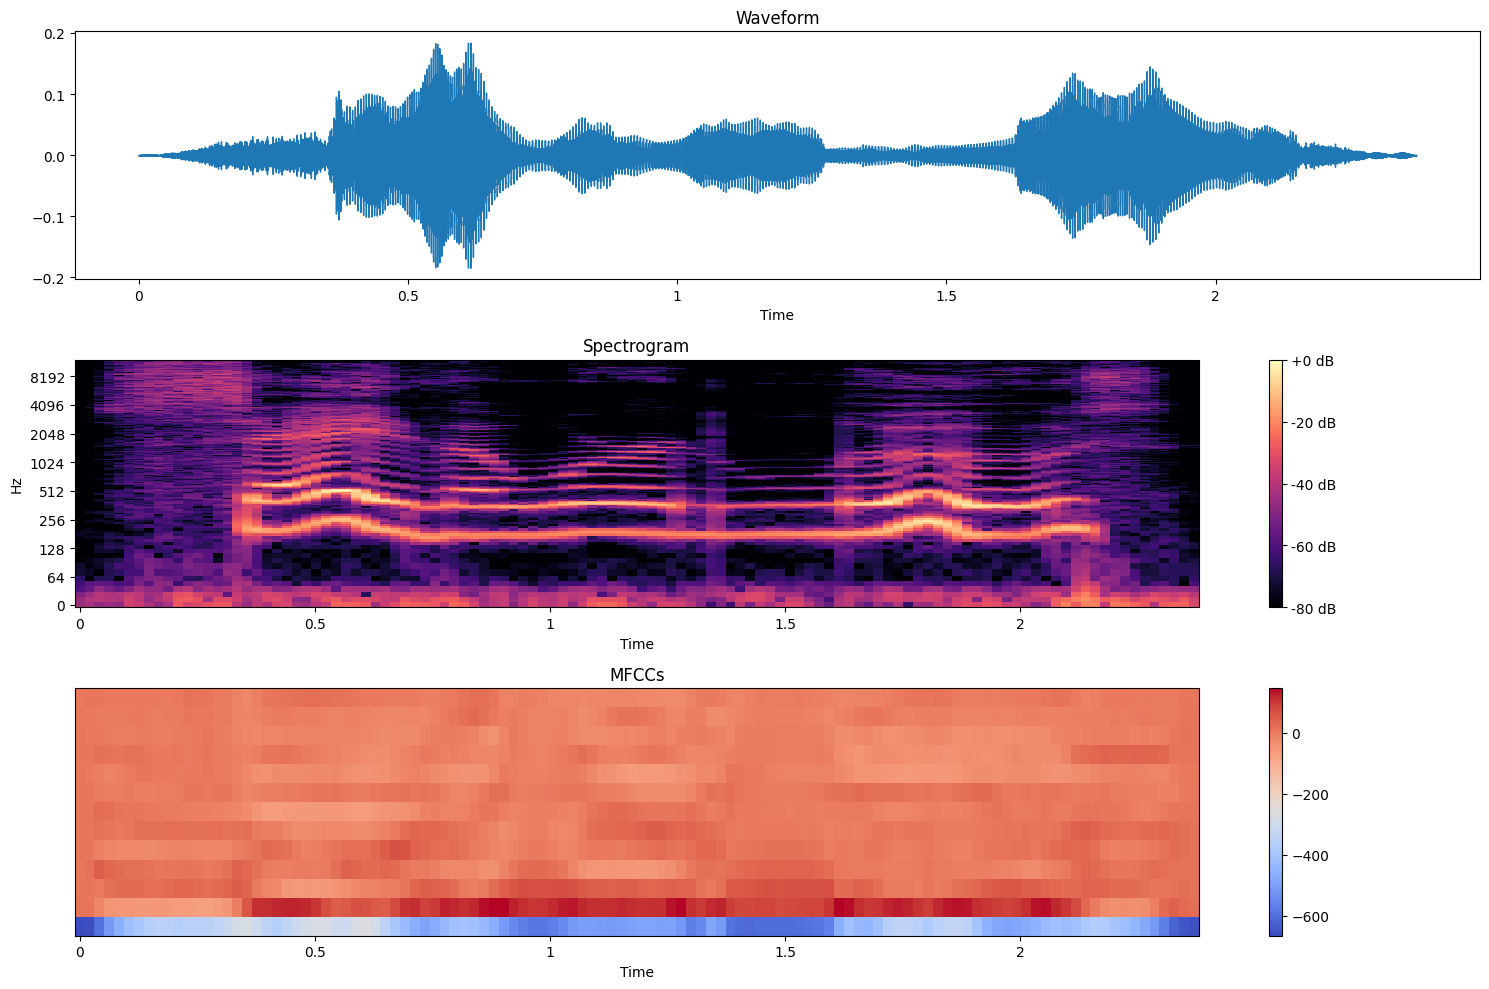

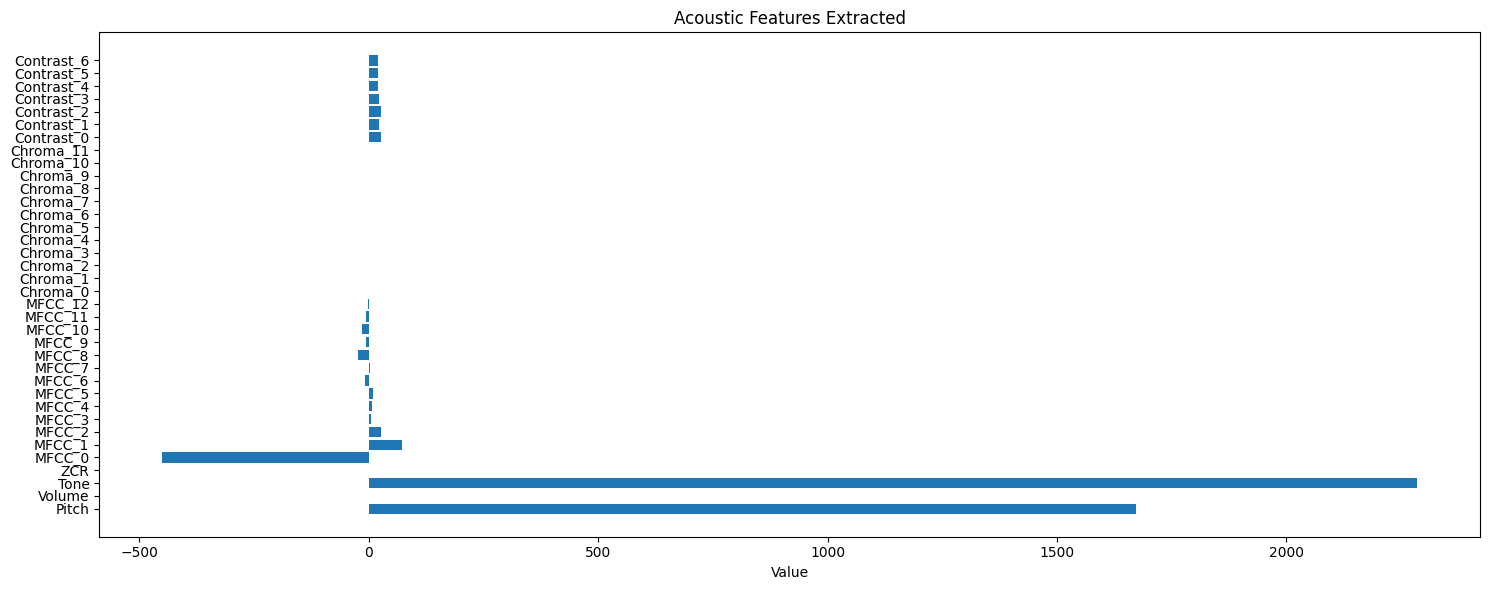


2. Speech Recognition Demonstration
---------------------------------
Analyzing sample file: OAF_rush_disgust.wav
Detected speech: say the word

3. Noise Filtering Demonstration
------------------------------


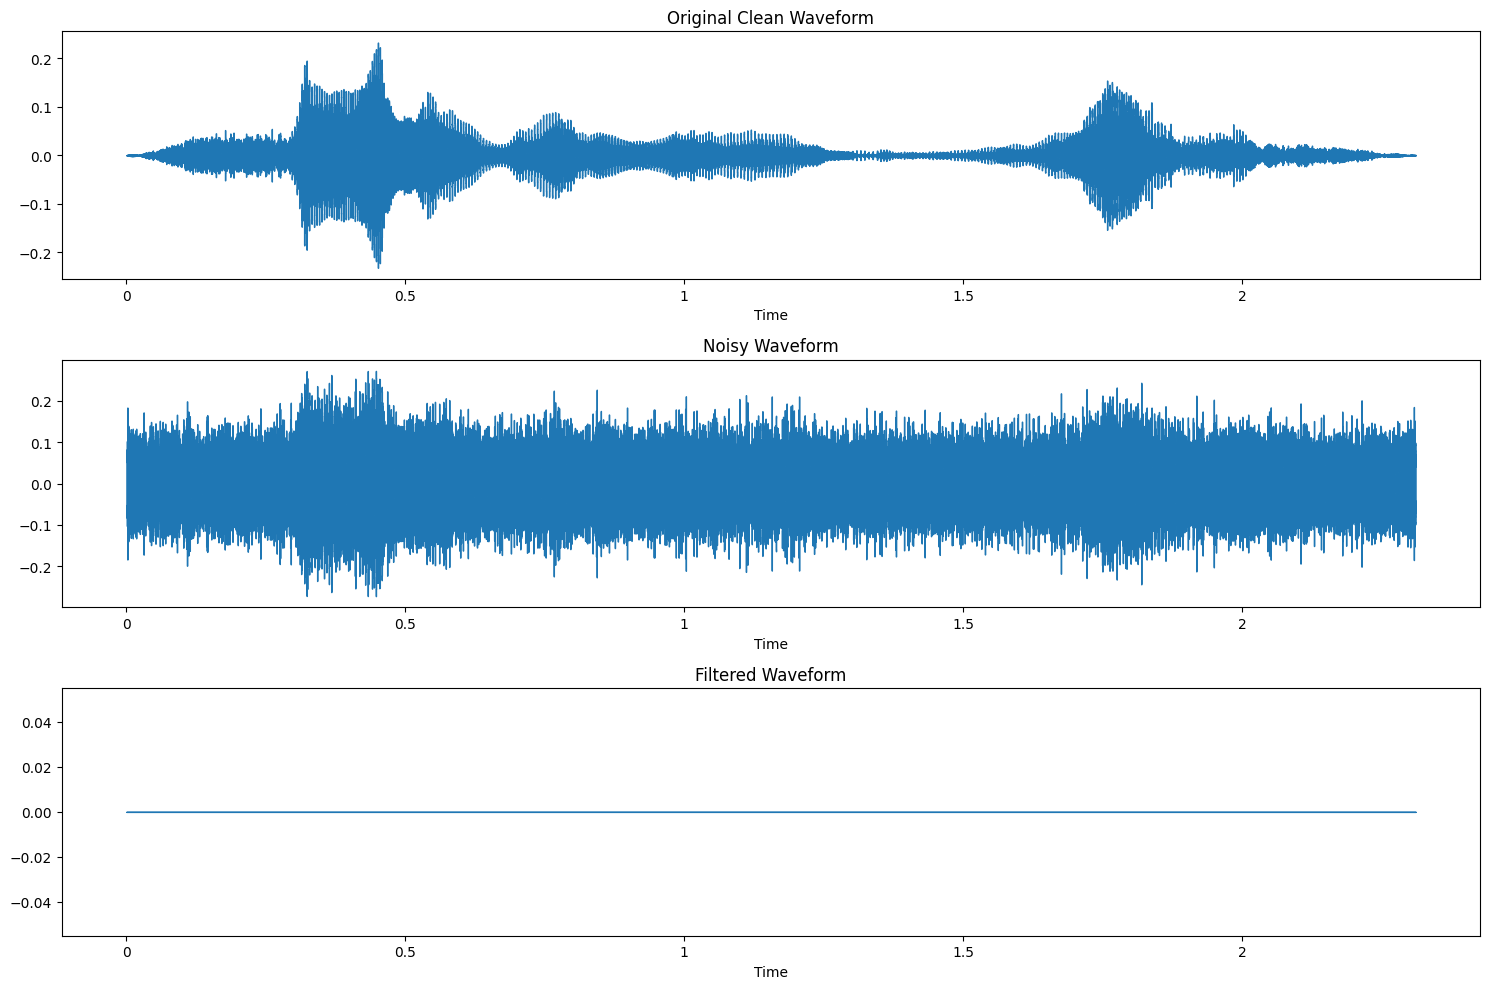

Original Clean Audio:


Noisy Audio:


Filtered Audio:



4. Emotional Detection Demonstration
----------------------------------
Extracting features for emotion detection...


  0%|          | 0/200 [00:00<?, ?it/s]

Training emotion detection model...
Iteration 1, loss = 0.65084024
Iteration 2, loss = 0.55012182
Iteration 3, loss = 0.46174386
Iteration 4, loss = 0.38506633
Iteration 5, loss = 0.31955195
Iteration 6, loss = 0.26409600
Iteration 7, loss = 0.21783106
Iteration 8, loss = 0.17958710
Iteration 9, loss = 0.14818664
Iteration 10, loss = 0.12240947
Iteration 11, loss = 0.10126871
Iteration 12, loss = 0.08402532
Iteration 13, loss = 0.06994674
Iteration 14, loss = 0.05846847
Iteration 15, loss = 0.04910055
Iteration 16, loss = 0.04143082
Iteration 17, loss = 0.03513973
Iteration 18, loss = 0.02995995
Iteration 19, loss = 0.02568673
Iteration 20, loss = 0.02214406
Iteration 21, loss = 0.01919816
Iteration 22, loss = 0.01674338
Iteration 23, loss = 0.01468441
Iteration 24, loss = 0.01294759
Iteration 25, loss = 0.01147954
Iteration 26, loss = 0.01023373
Iteration 27, loss = 0.00917391
Iteration 28, loss = 0.00826853
Iteration 29, loss = 0.00748949
Iteration 30, loss = 0.00681720
Iteration 31,

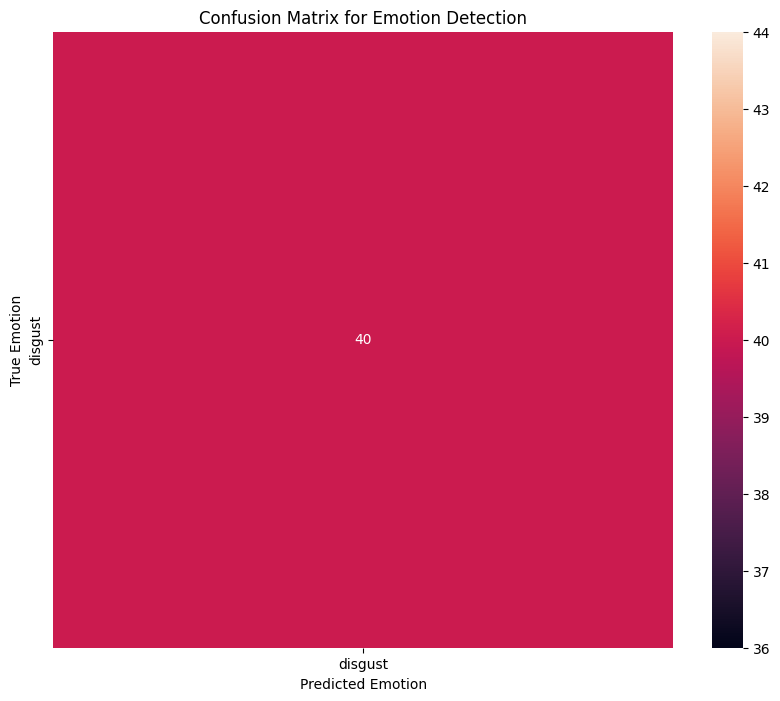

Emotion detection model saved as 'emotion_model.pkl'

Analyzing sample: OAF_lose_disgust.wav
Detected emotion: disgust


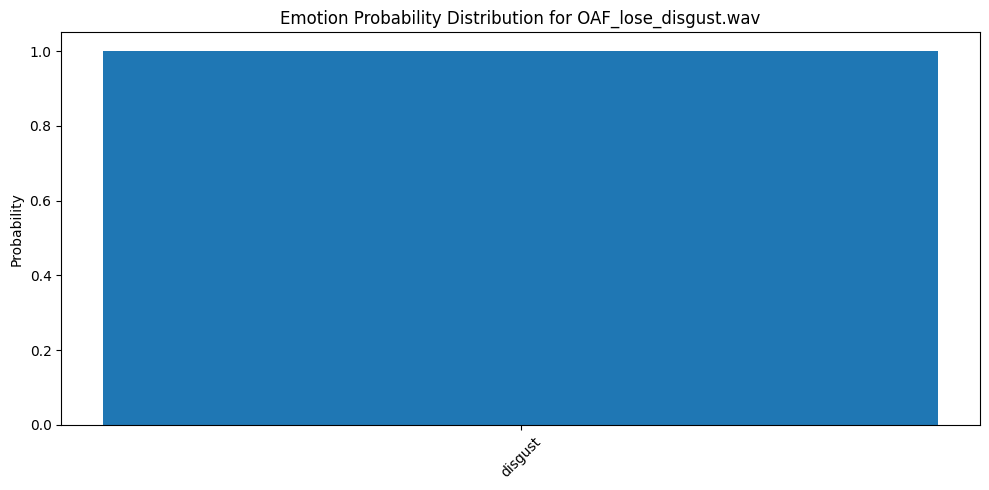


Analyzing sample: OAF_rush_disgust.wav
Detected emotion: disgust


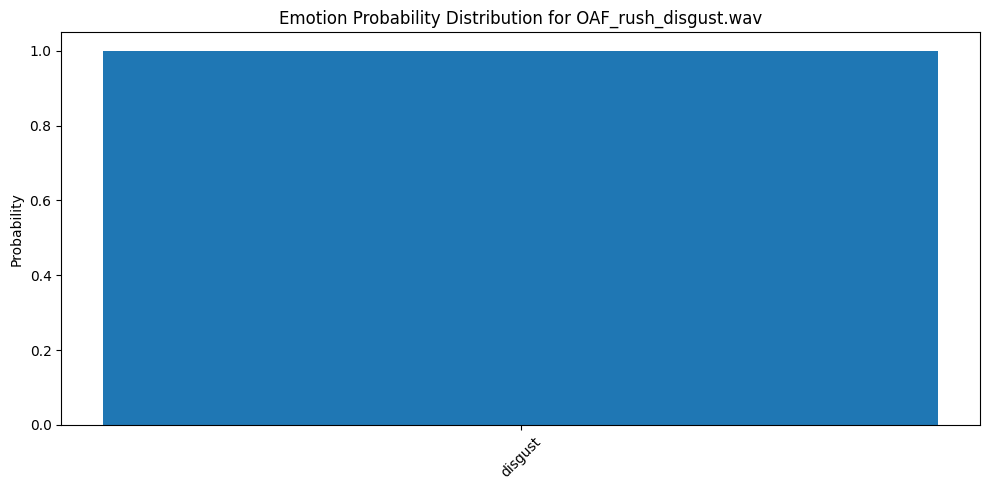


Analyzing sample: OAF_should_disgust.wav
Detected emotion: disgust


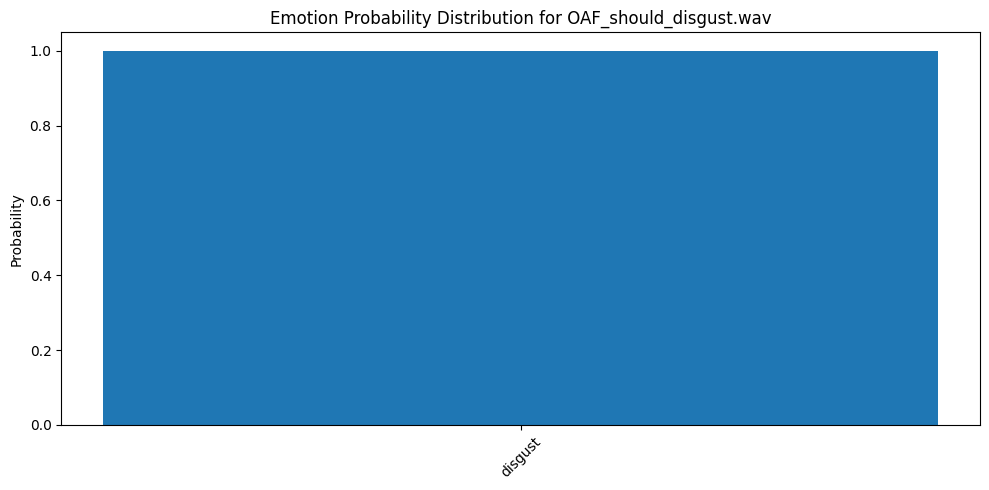


Analyzing sample: OAF_mess_disgust.wav
Detected emotion: disgust


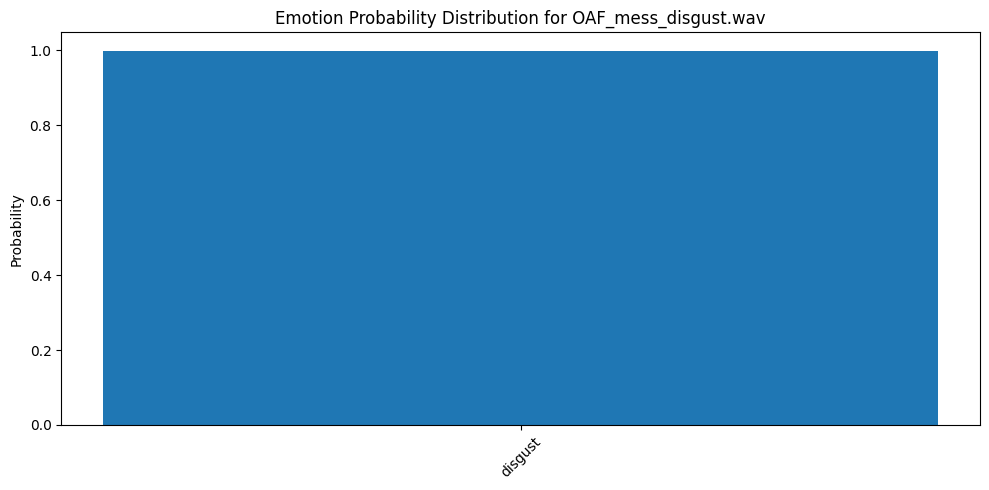

Exception in thread Thread-10 (_record_audio):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-a43c0678d4b2>", line 44, in _record_audio
  File "/usr/local/lib/python3.11/dist-packages/pyaudio/__init__.py", line 639, in open
    stream = PyAudio.Stream(self, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pyaudio/__init__.py", line 441, in __init__
    self._stream = pa.open(**arguments)
                   ^^^^^^^^^^^^^^^^^^^^
OSError: [Errno -9996] Invalid input device (no default output device)



5. Real-Time Processing
---------------------
Note: This will use your microphone for real-time processing.
In Google Colab, you'll need to grant microphone permissions.
Press Ctrl+C to stop the demonstration when you're done.
Real-time audio processing started. Press Ctrl+C to stop.
Real-time audio processing stopped.

Speech Detection System Demonstration Completed
Download the trained emotion model to use in your projects:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 if __name__ == "__main__":
    main()